This is more or less a test to figure out how to create repositories, etc

In [2]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project`


In [3]:
Pkg.add("Plots")
using Plots # plotting
Pkg.add("LinearAlgebra")
using LinearAlgebra
Pkg.add("CSV")
using CSV
Pkg.add("DataFrames")
using DataFrames

   Resolving package versions...


  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Project.toml`
  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Project.toml`
  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Project.toml`
  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Project.toml`
  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Manifest.toml`


Below starts the actual code. Steps as defined in project update.

## 0. cell matrices ##

In [4]:
length_cell=300; #m, FIXME
height_watershed_cells=3; #number of cells, FIXME
width_watershed_cells=5; #number of cells, FIXME

number_cells_total=height_watershed_cells*width_watershed_cells; #number of cells
area_cell= length_cell^2; #m^2

map_area=[
    0 .2 1 1 1
    .5 1 1 1 .2
    1 1 .3 0 0]; #fraction of each cell within watershed, FIXME

testDataFrame=CSV.read("bee4750grid watershed fractions.csv", DataFrame, header=false, delim=',');
testDataMatrix=Matrix(testDataFrame);
display(testDataMatrix)

map_ag=[
    0 .1 .5 .7 .6
    .2 .7 1 .4 .1
    0 1 .2 0 0]; #ag coefficient of each cell, FIXME

#=
map_ag=[
    0 0 0 0 0
    0 0 0 0 0
    0 0 0 0 0]; #ag coefficient of each cell, FIXME
=#

#curve numbers, from soil series -> hydraulic soil types -> weighted 
#avg approximation based on crop type and other land use
#ADJUST, FIXME
map_CN=90*ones(height_watershed_cells, width_watershed_cells);

outlet_cell_coords=[1,2]; #FIXME

map_distance=zeros(height_watershed_cells, width_watershed_cells);
for i in 1:height_watershed_cells
    for j in 1:width_watershed_cells
        map_distance[i,j] = length_cell*sqrt((i-outlet_cell_coords[1])^2+(j-outlet_cell_coords[2])^2);
    end
end

map_elevation=[
    20 40 10 10 8
    30 20 15 13 80
    20 10 40 40 40]; #height above outlet, FEET, FIXME


26×33 Matrix{Float64}:
 0.0   0.0   0.0   0.0   0.0  0.0  …  0.65  0.5   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0  0.0     1.0   1.0   0.5   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0  0.0     1.0   1.0   1.0   0.5   0.2   0.0
 0.0   0.0   0.0   0.0   0.0  0.0     1.0   1.0   1.0   1.0   0.7   0.1
 0.0   0.0   0.0   0.0   0.0  0.0     1.0   1.0   1.0   1.0   0.95  0.15
 0.0   0.0   0.0   0.2   0.4  0.2  …  1.0   1.0   1.0   1.0   0.65  0.0
 0.15  0.75  0.85  0.95  1.0  1.0     1.0   1.0   1.0   1.0   0.45  0.0
 0.0   0.2   0.6   1.0   1.0  1.0     1.0   1.0   1.0   0.45  0.05  0.0
 0.0   0.0   0.1   0.9   1.0  1.0     1.0   1.0   0.8   0.1   0.0   0.0
 0.0   0.0   0.0   0.6   1.0  1.0     1.0   0.95  0.05  0.0   0.0   0.0
 ⋮                            ⋮    ⋱                    ⋮           
 0.0   0.0   0.0   0.0   0.0  0.0     0.45  0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0  0.0     0.95  0.05  0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0  0.0     1.0  

## 1. calculating manure and phosphorus ##

In [74]:
depth_applied=.5; #inches, ADJUST FIXME
depth_mixed=.5; #inches, ADJUST FIXME

d_interacting= 0.5*depth_applied/depth_mixed*2.54/100; #m

density_manure=63*16.0185; #kg/m^3

#from Pagliari, 2014
phosphorus_in_manure_amount=10.55 #g/kg
inorg_fract=.695;

## 2. calculating idealized storm ##

In [60]:
precip_storm_total=250; #mm, to be tweaked FIXME
duration_storm=60; #min, to be tweaked FIXME

intensity_storm=precip_storm_total/duration_storm; #mm/min

## 3. defining calculations for each cell ##

In [153]:
t_runoff_start_matrix=zeros(height_watershed_cells, width_watershed_cells); #minutes
t_c_matrix=zeros(height_watershed_cells, width_watershed_cells); #minutes
vol_matrix=zeros(height_watershed_cells, width_watershed_cells); #m^3
C_matrix=zeros(height_watershed_cells, width_watershed_cells); #g/m^3

number_mins=300; #length of time arrays

rate_vol_outlet=1.566*49.3/38.6*ones(number_mins); #m^3/sec, array, per minute
C_outlet=11.396*ones(number_mins); #mg/L baseflow concentration, array, per minute

M_cumulative=0;

for i in 1:height_watershed_cells
    for j in 1:width_watershed_cells
        area_cell_inside=area_cell*map_area[i,j];
        area_ag=area_cell*map_ag[i,j];
        CN=map_CN[i,j];
        distance=map_distance[i,j];
        
        S=25400/CN-254; #mm
        Ia=0.2*S; #mm

        depth_Q=(precip_storm_total-Ia)^2/(precip_storm_total-Ia+S); #mm
        vol_Q=depth_Q*area_cell_inside/1000; #m^3
        vol_Q_ag=vol_Q*area_ag/area_cell_inside;
        vol_Q_ag_liters=vol_Q_ag*1000;

        t_runoff_start=duration_storm*Ia/depth_Q; #min
        rate_vol_Q=vol_Q/(duration_storm-t_runoff_start)/60; #m^3/sec

        M_interacting_manure=d_interacting*density_manure*area_ag; #kg
        M_runoff_ag=vol_Q*1000; #kg

        M_interacting_inorg=M_interacting_manure*.733; #g
        
        M_dissolved_inorg=0; #g

        #piecewise function built from plot in Pagliari, 2014
        if 0<vol_Q_ag_liters/M_interacting_manure<=12.5
            M_dissolved_inorg=((vol_Q_ag_liters/M_interacting_manure-1.7)/10.8*.44+.07)/100*M_interacting_inorg; #g
        elseif 12.5<vol_Q_ag_liters/M_interacting_manure <= 50.8
            M_dissolved_inorg=((vol_Q_ag_liters/M_interacting_manure-12.5)/(50.8-12.5)*.46+.51)/100*M_interacting_inorg; #g
        elseif 50.8<vol_Q_ag_liters/M_interacting_manure
            M_dissolved_inorg=((vol_Q_ag_liters/M_interacting_manure-50.8)/(101.7/50.8)*(0-.06)+.97)/100*M_interacting_inorg; #g
        end

        #println(M_dissolved_inorg) #FIXME temp

        t_runoff_start_matrix[i,j]=t_runoff_start;
        t_c_matrix[i,j]=0.0078*map_distance[i,j]^0.77/(map_elevation[i,j]/map_distance[i,j])^0.385; #minutes
        vol_matrix[i,j]=vol_Q;

        if !isnan(M_dissolved_inorg) && vol_Q != 0 #avoid NaN values in the concentration matrix when no runoff is occurring, etc
            C_matrix[i,j]=M_dissolved_inorg/vol_Q; #g/m^3=mg/L
        end
        
        M_cumulative += M_dissolved_inorg; #g, doesn't consider baseflow phosphorus

        for k=1:length(rate_vol_outlet)
            if t_runoff_start+t_c_matrix[i,j]<k<t_runoff_start+duration_storm+t_c_matrix[i,j]
                temp_C_outlet=(C_outlet[k]*rate_vol_outlet[k]+C_matrix[i,j]*rate_vol_Q)/(rate_vol_outlet[k]+rate_vol_Q);
                C_outlet[k] = temp_C_outlet
                rate_vol_outlet[k] += rate_vol_Q;
            end
        end
    end
end


println("Mass from runoff is ",M_cumulative/1000, " kg"); #returns cumulative mass in kg
println("Mass from baseflow is ", 1.566 *49.3/38.6*number_mins*60*11.396/1000, " kg")
println("(Sanity check): Total mass is ", dot(rate_vol_outlet, transpose(C_outlet))/1000*60, " kg");

Mass from runoff is 26.28080753959076 kg
Mass from baseflow is 410.2761939481865 kg
(Sanity check): Total mass is 437.25209490078817 kg


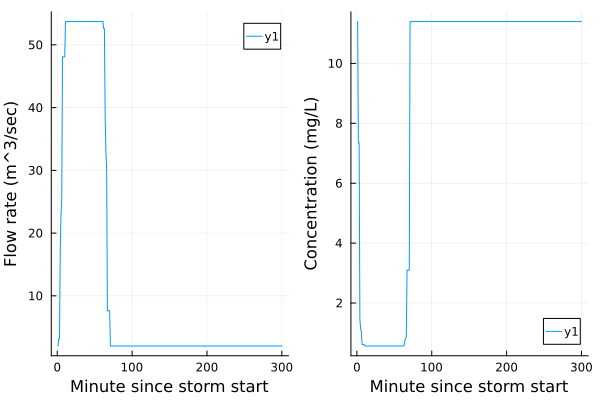

In [161]:
plot_flow=plot(1:number_mins, rate_vol_outlet, xlabel="Minute since storm start", ylabel="Flow rate (m^3/sec)")
plot_C=plot(1:number_mins, C_outlet, xlabel="Minute since storm start", ylabel="Concentration (mg/L)")
plot(plot_flow, plot_C)
